# CLTV *(Customer Lifetime Value)* Prediction with BG-NBD and Gamma-Gamma using FLO's Dataset

In [1]:
# Libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

# Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Task 1: 
Data Preparation.

Step 1: Read the flo_data_20K.csv data. Make a copy of the dataframe.

In [2]:
df_ = pd.read_csv('flo_data_20k.csv')

In [3]:
df = df_.copy()

In [4]:
def check_df(dataframe, head=7, tail=7):
    '''
    Prints the general information about the given dataframe e.g. shape, head,
    tail, info, descriptive statistics, etc.

    Parameters
    ----------
    dataframe : DataFrame
        The dataframe that we want to have general information about.
    head: int
        Prints the first n rows of the dataframe.
    tail: int
        Prints the last n rows of the dataframe.
    '''
    print('####### Shape #######')
    print(dataframe.shape)
    print('####### Info #######')
    print(dataframe.info())
    print('####### Head #######')
    print(dataframe.head(head))
    print('####### Tail #######')
    print(dataframe.tail(tail))
    print('####### Descriptive Statistics #######')
    print(dataframe.describe([0.05, 0.25, 0.50, 0.75 ,0.95, 0.99]).T)
    print('####### NA #######')
    print(dataframe.isnull().sum())
    print('####### Number of Unique Values #######')
    print(dataframe.nunique())


check_df(df)

####### Shape #######
(19945, 12)
####### Info #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11 

Step 2: Define the outlier_thresholds and replace_with_thresholds functions required to suppress outliers.
Note: When calculating cltv, frequency values ​​must be integers. Therefore, round the lower and upper limits with round().

In [5]:
# Outlier thresholds
def outlier_thresholds(dataframe, variable, q1=0.01, q3=0.99):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
# Replacing with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit)

Step 3: If the variables 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online' have outliers, suppress any outliers.

In [7]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [8]:
# Suppressing outliers
for col in num_cols:
    replace_with_thresholds(df, col)

Step 4: Omnichannel means that customers shop from both online and offline platforms. Create new variables for each customer's total purchases and spend.

In [9]:
# Total purchase
df['total_order_omnichannel'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['total_order_omnichannel'].head()

0    5.000
1   21.000
2    5.000
3    2.000
4    2.000
Name: total_order_omnichannel, dtype: float64

In [10]:
# Total spend
df['total_price_omnichannel'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']
df['total_price_omnichannel'].head()

0    939.370
1   2013.550
2    585.320
3    121.970
4    209.980
Name: total_price_omnichannel, dtype: float64

Step 5: Examine the variable types. Change the type of variables that express date to date.

In [11]:
date_cols = df.columns[df.columns.str.contains('date')]
date_cols

Index(['first_order_date', 'last_order_date', 'last_order_date_online',
       'last_order_date_offline'],
      dtype='object')

In [12]:
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [13]:
df[['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         19945 non-null  datetime64[ns]
 1   last_order_date          19945 non-null  datetime64[ns]
 2   last_order_date_online   19945 non-null  datetime64[ns]
 3   last_order_date_offline  19945 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 623.4 KB


# Task 2: 
Creating the CLTV Data Structure.

Step 1: Take 2 days after the date of the last purchase in the dataset as the date of analysis.

In [14]:
# Max. last order date in the dataset
df['last_order_date'].max()

Timestamp('2021-05-30 00:00:00')

In [15]:
# Analysis Date: 2 days after maximum last order date (2021, 6, 1) 
analysis_date = dt.datetime(2021, 6, 1)
analysis_date

datetime.datetime(2021, 6, 1, 0, 0)

Step 2: Create a new cltv dataframe with 'customer_id', 'recency_cltv_weekly', 'T_weekly', 'frequency' and 'monetary_cltv_avg' values.
Monetary value will be expressed as average value per purchase, recency and tenure values ​​will be expressed in weekly terms.

In [16]:
cltv_df = pd.DataFrame()

cltv_df['customer_id'] = df['master_id']

# Recency Weekly
cltv_df['recency_cltv_weekly'] = (df['last_order_date'] - df['first_order_date']).dt.days / 7

# Tenure Weekly
cltv_df['T_weekly'] = (analysis_date - df['first_order_date']).dt.days / 7

# Frequency
cltv_df['frequency'] = df['total_order_omnichannel']

# Monetary
cltv_df['monetary_cltv_avg'] = df['total_price_omnichannel'] / df['total_order_omnichannel']

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990


# Task 3: 
Establishment of BG/NBD, Gamma-Gamma Models and calculation of CLTV.

Step 1: Fit BG/NBD model.
- Estimate expected purchases from customers in 3 months and add 'exp_sales_3_month' to cltv dataframe.
- Estimate expected purchases from customers in 6 months and add 'exp_sales_6_month' to cltv dataframe. 
- Examine the 10 people who will make the most purchases in the 3rd and 6th months.

In [17]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [18]:
# - Estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe. 
cltv_df['exp_sales_3_month'] = bgf.predict(4 * 3, 
                                           cltv_df['frequency'], 
                                           cltv_df['recency_cltv_weekly'], 
                                           cltv_df['T_weekly'])

In [19]:
# - Estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe. 
cltv_df['exp_sales_6_month'] = bgf.predict(4 * 6, 
                                           cltv_df['frequency'], 
                                           cltv_df['recency_cltv_weekly'], 
                                           cltv_df['T_weekly'])

In [20]:
# - Examine the 10 people who will make the most purchases in the 3rd and 6th months.
# 3rd month
cltv_df.sort_values('exp_sales_3_month',  ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,4.656,9.312
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.714,40.000,29.000,165.298,3.374,6.748
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857,33.286,25.000,97.440,3.142,6.285
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.084,6.168
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.000,46.429,27.000,141.355,3.001,6.003
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.143,111.857,43.000,157.113,2.978,5.956
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.143,147.143,49.000,161.847,2.830,5.660
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.714,64.143,29.000,168.881,2.793,5.587
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,2.781,5.561
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.571,113.429,40.000,176.200,2.763,5.527


In [21]:
# 6th month
cltv_df.sort_values('exp_sales_6_month',  ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,4.656,9.312
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.714,40.000,29.000,165.298,3.374,6.748
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857,33.286,25.000,97.440,3.142,6.285
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.084,6.168
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.000,46.429,27.000,141.355,3.001,6.003
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.143,111.857,43.000,157.113,2.978,5.956
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.143,147.143,49.000,161.847,2.830,5.660
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.714,64.143,29.000,168.881,2.793,5.587
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,2.781,5.561
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.571,113.429,40.000,176.200,2.763,5.527


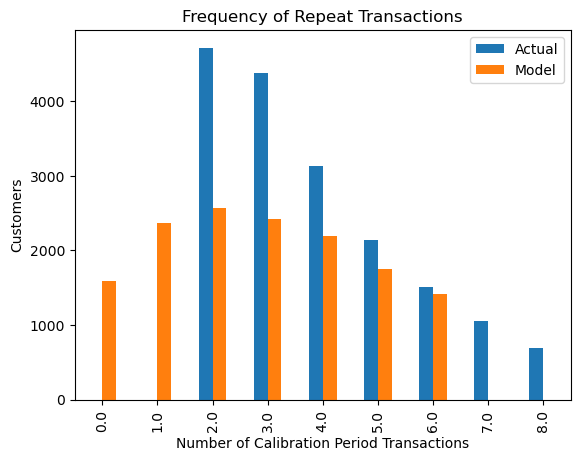

In [22]:
# Evaluation of forecast results
plot_period_transactions(bgf)
plt.show()

Step 2: Fit the Gamma-Gamma model. Estimate the average value of the customers and add it to the cltv dataframe as 'exp_average_value'.

In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], 
        cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [24]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], 
                                                                       cltv_df['monetary_cltv_avg'])

In [25]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948,193.633
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966,96.665
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341,120.968
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401,67.320
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792,114.325


Step 3: Calculate 6 months CLTV and add it to the dataframe with the name cltv.
- Observe the 20 people with the highest cltv value.

In [26]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6, # 6 months
                                   freq='W', # Weekly T frequency
                                   discount_rate=0.01)
cltv_df['cltv'] = cltv

In [27]:
# - Observe the 20 people with the highest cltv value.
cltv_df.sort_values('cltv',ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1401.800,1.094,2.189,1449.060,3327.777
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,758.085,1.970,3.940,767.361,3172.394
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7.000,1106.467,0.722,1.444,1127.612,1708.982
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.286,74.571,16.000,501.874,1.565,3.131,506.167,1662.613
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,4.656,9.312,166.712,1628.887
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,601.226,1.265,2.531,611.493,1623.813
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690,0.794,1.588,923.680,1538.856
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,2.781,5.561,262.073,1529.228
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.084,6.168,229.607,1485.819
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857,15.571,3.000,743.587,0.872,1.743,778.050,1423.000


# Task 4: 
Creating Segments by CLTV.

Step 1: Divide all your 6 month old customers into 4 groups (segments) and add the group names to the dataset (Add it to the dataframe with the name cltv_segment).

In [28]:
cltv_df['cltv_segment'] = pd.qcut(cltv_df['cltv'], 4, labels=['D', 'C', 'B', 'A'])

Step 2: Examine the recency, frequency and monetary averages of the segments.

In [29]:
cltv_df.groupby('cltv_segment')[['frequency', 'recency_cltv_weekly', 'T_weekly', 'monetary_cltv_avg', 'cltv']].agg(['mean', 'count', 'sum'])

frequency                 recency_cltv_weekly                   \
                  mean count       sum                mean count        sum   
cltv_segment                                                                  
D                3.769  4987 18795.000             139.000  4987 693193.857   
C                4.405  4986 21962.000              92.630  4986 461850.857   
B                5.093  4986 25392.000              81.988  4986 408794.000   
A                6.647  4986 33140.000              67.427  4986 336191.714   

             T_weekly                  monetary_cltv_avg                    \
                 mean count        sum              mean count         sum   
cltv_segment                                                                 
D             162.183  4987 808807.714            93.152  4987  464547.046   
C             112.818  4986 562512.143           125.789  4986  627181.647   
B             100.327  4986 500228.000           160.637  4986  800933.959   
A              82.550  4986 411592.857           228.831  4986 1140952.075   

                cltv                    
                mean count         sum  
cltv_segment                            
D             80.340  4987  400657.955  
C            138.312  4986  689621.178  
B            199.533  4986  994870.784  
A            362.316  4986 1806505.089

In [30]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948,193.633,395.733,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966,96.665,199.431,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341,120.968,170.224,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401,67.320,98.946,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792,114.325,95.012,D


Step 3: Make short 6-month action suggestions to the management for 2 groups that you will choose from among 4 groups.

In [31]:
cltv_df.groupby('cltv_segment').agg({'exp_sales_6_month': ['count',	'sum', 'mean', 'median', 'std', 'min', 'max']})

exp_sales_6_month                                        
                         count      sum  mean median   std   min   max
cltv_segment                                                          
D                         4987 4078.328 0.818  0.821 0.246 0.299 2.100
C                         4986 5239.769 1.051  1.019 0.256 0.324 3.137
B                         4986 5994.219 1.202  1.151 0.315 0.354 3.564
A                         4986 7708.626 1.546  1.423 0.593 0.424 9.312

Since segment A is the most valuable group, money points gift or certain special offers can be provided.
Since C and B groups are close to each other, they can be considered as a single group or a certain amount of discount can be provided for the C group and it can be approached to the B group.


In [32]:
# Export as csv file
cltv_df.to_csv('cltv_prediction_flo.csv', index=False)

# Bonus: 
Functionalize the whole process.

In [33]:
def create_cltv_df(dataframe):

    # Data Preperation
    num_cols = ['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online']
    for col in num_cols:
        replace_with_thresholds(dataframe, col)

    dataframe['total_order_omnichannel'] = dataframe['order_num_total_ever_online'] + dataframe['order_num_total_ever_offline']
    dataframe['total_price_omnichannel'] = dataframe['customer_value_total_ever_online'] + dataframe['customer_value_total_ever_offline']
    dataframe = dataframe[~(dataframe['total_price_omnichannel'] == 0) | (dataframe['total_order_omnichannel'] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains('date')]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Creating the CLTV Data Structure
    dataframe['last_order_date'].max()  # Timestamp('2021-05-30 00:00:00')
    analysis_date = dt.datetime(2021, 6, 1) # 2 days after maximum last order date
    cltv_df = pd.DataFrame()
    cltv_df['customer_id'] = dataframe['master_id']
    cltv_df['recency_cltv_weekly'] = (dataframe['last_order_date']- dataframe['first_order_date']).dt.days / 7
    cltv_df['T_weekly'] = (analysis_date - dataframe['first_order_date']).dt.days / 7
    cltv_df['frequency'] = dataframe['total_order_omnichannel']
    cltv_df['monetary_cltv_avg'] = dataframe['total_price_omnichannel'] / dataframe['total_order_omnichannel']
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

    # Fit BG/NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])
    cltv_df['exp_sales_3_month'] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])
    cltv_df['exp_sales_6_month'] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])

    # The Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                           cltv_df['monetary_cltv_avg'])

    # CLTV Prediction
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'],
                                       cltv_df['monetary_cltv_avg'],
                                       time=6,
                                       freq='W',
                                       discount_rate=0.01)
    cltv_df['cltv'] = cltv

    # CLTV Segmentation
    cltv_df['cltv_segment'] = pd.qcut(cltv_df['cltv'], 4, labels=['D', 'C', 'B', 'A'])
    return cltv_df


cltv_df = create_cltv_df(df)

In [34]:
cltv_df.head(10)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948,193.633,395.733,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966,96.665,199.431,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341,120.968,170.224,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401,67.320,98.946,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792,114.325,95.012,D
5,e585280e-aae1-11e9-a2fc-000d3a38a36f,120.857,132.286,3.000,66.953,0.384,0.767,71.348,57.430,D
6,c445e4ee-6242-11ea-9d1a-000d3a38a36f,32.571,64.857,4.000,93.983,0.652,1.304,98.133,134.278,C
7,3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f,12.714,54.571,2.000,81.815,0.520,1.040,89.570,97.701,D
8,cfbda69e-5b4f-11ea-aca7-000d3a38a36f,58.429,70.714,5.000,210.938,0.708,1.416,217.301,322.735,A
9,1143f032-440d-11ea-8b43-000d3a38a36f,61.714,96.000,2.000,82.980,0.395,0.789,90.815,75.222,D
